 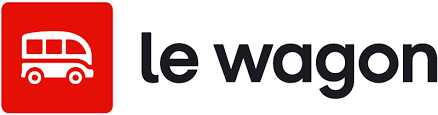

# DACO Online Store retention matrix

We will study the impact of signing contracts with top-name football players on DACO's online store.

- During the first quarter of 2021 it was announced the arrival of the famous player "El Bicho" to DACO FC.
- Thanks to this incorporation, Daco reached the finals of the South American Cup in December 2021.
- Besides, to promote this new incorporation, DACO offered ticket discounts to all games of seasons 2021/2022 for regular users of the online store.

## Turnover analysis

a) Load DACO's online store orders by executing the following cell. It takes two minutes of execution.

In [ ]:
from google.colab import auth
import pandas as pd

# Will collect your credentials
auth.authenticate_user()

# Query Bigquery
query = "SELECT * FROM `da-bootcamp-with-football.course30.daco_orders` ORDER BY date_date"

df_orders = pd.read_gbq(query, project_id="da-bootcamp-with-football")

b) Convert column `date_date` to datetime.

In [ ]:
import pandas as pd

# Convert 'date_date' column to datetime
df_orders['date_date'] = pd.to_datetime(df_orders['date_date'])

# Verify the conversion
print(df_orders.dtypes)


c) Set column `date_date` as index

In [ ]:
# Set 'date_date' column as index
df_orders.set_index('date_date', inplace=True)

# Verify the index setting
print(df_orders.head())


d) Calculate total turnover per year using `.resample()` method and store result in a `df_y_turnover` variable.

In [ ]:
# Calculate total turnover per year
df_y_turnover = df_orders.resample('Y').sum()

# Display the resulting DataFrame
print(df_y_turnover)


e) Calculate percentage change 2021 and 2022 vs 2020.
What was the impact of the arrival of "El Bicho"?

In [ ]:
# Calculate the turnover for the years 2020, 2021, and 2022
turnover_2020 = df_y_turnover.loc['2020', 'turnover']
turnover_2021 = df_y_turnover.loc['2021', 'turnover']
turnover_2022 = df_y_turnover.loc['2022', 'turnover']

# Calculate the percentage change in turnover from 2020 to 2021 and from 2020 to 2022
percentage_change_2021 = ((turnover_2021 - turnover_2020) / turnover_2020) * 100
percentage_change_2022 = ((turnover_2022 - turnover_2020) / turnover_2020) * 100

# Assess the impact of Lionel Messi's arrival
impact_of_messi = "Positive" if percentage_change_2021 > 0 else "Negative"

# Display the results
print(f"Percentage change in turnover from 2020 to 2021: {percentage_change_2021:.2f}%")
print(f"Percentage change in turnover from 2020 to 2022: {percentage_change_2022:.2f}%")
print(f"Imp


f) Let's have a closer look if the turnover increase comes from additional users of the online store.

Using `resample()` function, create a new variable `df_m_turnover` which is total turnover per month.

In [ ]:
# Resample the original DataFrame by month and calculate total turnover per month
df_m_turnover = df_orders.resample('M').sum()

# Display the resulting DataFrame
print(df_m_turnover)


g) Plot the result using Plotly express.
Can you identify a peak in this chart? Which month is it?

In [ ]:
import plotly.express as px

# Plot the total turnover per month
fig = px.line(df_m_turnover, x=df_m_turnover.index, y='turnover', title='Total Turnover per Month')
fig.show()


h) Plot a similar chart but showing the average turnover instead. What do you see?

In [ ]:
import plotly.express as px

# Calculate the average turnover per month
average_turnover_per_month = df_m_turnover['turnover'].mean()

# Create a DataFrame with the average turnover for each month
df_avg_turnover = pd.DataFrame({'month': df_m_turnover.index.month, 'average_turnover': average_turnover_per_month})

# Plot the average turnover per month
fig = px.line(df_avg_turnover, x='month', y='average_turnover', title='Average Turnover per Month')
fig.show()


i) Let's consider that a customer is new when a first order is placed.
What does this code do?


In [ ]:
df_first_orders = df_orders.reset_index().groupby("customers_id", as_index=False).first()
df_first_orders

j) From df_first_orders, compute the number of new users per month. Store the result in a new variable df_new_customers.

Hint: `resample()` function has a "on" parameter...

In [ ]:
# Set the index of df_first_orders to the 'date_date' column
df_first_orders.set_index('date_date', inplace=True)

# Resample the DataFrame by month and count the number of unique customers for each month
df_new_customers = df_first_orders.resample('M', on='date_date').nunique()

# Rename the columns for clarity
df_new_customers.rename(columns={'customers_id': 'new_customers'}, inplace=True)

# Display the resulting DataFrame
print(df_new_customers)


k) Plot it in a graph with Plotly express. Which months have the most new customers ? Why do we have so many new users before Jul 2020? Is it correct?

In [ ]:
import plotly.express as px

# Plot the number of new customers per month
fig = px.line(df_new_customers, x=df_new_customers.index, y='new_customers', title='Number of New Customers per Month')
fig.show()


l) What can you conclude?

## Matrix retention

We will now study how long customers stay to have a better understanding of the previous analysis. We will analyse the efect of the discounts campaign with a cohort analysis.

a) We won't do resampling methods anymore. Use `.reset_index()` method on `df_orders` to bring back `date_date` as column and not as an index anymore.

In [ ]:
# Reset the index of df_orders to bring back date_date as a column
df_orders = df_orders.reset_index()

# Display the DataFrame to verify the changes
print(df_orders.head())


b) In `df_first_orders` variables, rename column `date_date` to `member_at`.
Use the `.rename(columns={"old_name":"new_name"})` method.

In [ ]:
# Rename the column 'date_date' to 'member_at' in df_first_orders
df_first_orders = df_first_orders.rename(columns={"date_date": "member_at"})

# Display the DataFrame to verify the changes
print(df_first_orders.head())


c) Add column `member_at` to `df_orders` variable.
For that, we will merge `df_orders` and `df_first_orders` together. Keep only `customers_id` and `member_at` when performing the merge to avoid duplicate columns.

We will store the result in a `df_cohort` variable.

In [ ]:
# Merge df_orders and df_first_orders, keeping only 'customers_id' and 'member_at'
df_cohort = df_orders.merge(df_first_orders[['customers_id', 'member_at']], on='customers_id', how='left')

# Display the resulting DataFrame
print(df_cohort.head())


d) We will create cohorts based on `member_at` month. Execute the cell below to do so.

Note that because `member_at` is of type datetime, we can cast it to a specific format like datetime64[M].

What does it do exactly?

In [ ]:
df_cohort["cohort"] = df_cohort["member_at"].values.astype('datetime64[M]')
df_cohort[["member_at", "cohort"]]

e) In a new variable `df_cohort_size` calculate the number of unique users per `cohort`. You can use `.nunique()` function to do it.

In [ ]:
# Calculate the number of unique users per cohort
df_cohort_size = df_cohort.groupby('cohort')['customers_id'].nunique().reset_index()

# Rename the columns for clarity
df_cohort_size.columns = ['cohort', 'unique_users']

# Display the resulting DataFrame
print(df_cohort_size)


f) For this analysis, we will not take orders made on december 2021 because we do not have all of them. We will only take orders made by customers with member_at after 2019.

Filter `df_cohort` on `date_date` < "2022-12-01" and `member_at` > "2020-12-31".

Filter `df_cohort_size` on "2021-01-01":"2022-11-01"

In [ ]:
# Filter df_cohort
df_cohort_filtered = df_cohort[(df_cohort['date_date'] < "2022-12-01") & (df_cohort['member_at'] > "2020-12-31")]

# Filter df_cohort_size
df_cohort_size_filtered = df_cohort_size[(df_cohort_size['cohort'] >= "2021-01-01") & (df_cohort_size['cohort'] < "2022-11-01")]

# Display the resulting DataFrames
print("Filtered df_cohort:")
print(df_cohort_filtered.head())

print("\nFiltered df_cohort_size:")
print(df_cohort_size_filtered.head())


g) We will consider a customer being active when they make an order. We won't consider having made a first order as being active because it's more like a subscription.

Filter `df_cohort` on `date_date` > `member_at` to do so.

In [ ]:
# Filter df_cohort on date_date > member_at
df_cohort_active = df_cohort[df_cohort['date_date'] > df_cohort['member_at']]

# Display the resulting DataFrame
print(df_cohort_active.head())


h) Look at the cell below and comment what it does.
Execute the cell to create `nb_months` column.

In [ ]:
import numpy as np

df_cohort["nb_months"] = (df_cohort["date_date"] - df_cohort["member_at"]) / np.timedelta64(1,'M')
df_cohort["nb_months"] = df_cohort["nb_months"].astype(int) + 1

i) To be able to create a rentention matrix, we will have to count the number of unique `customer_ids` by `cohort` and `nb_months`. Do it and store the result in a variable `df_retention`.

Don't forget to use `as_index=False in groupby()` function as we don't want put `cohort` and `nb_months` as indexes.

In [ ]:
# Create the retention matrix
df_retention = df_cohort_active.groupby(['cohort', 'nb_months'], as_index=False)['customers_id'].nunique()

# Display the resulting DataFrame
print(df_retention.head())


j) From `df_retention` create a pivot table with `cohort` as index and `nb_months` as columns.

Complete the code below to do it.

This result is what we call a retention matrix:
- A row shows the percentage of users of the cohort that are still active in month 1, 2, 3, ..., X after their first purchase.
- A column shows the percentage of users that are still active in month X after their first purchase for the different cohorts.

In [ ]:
# to be completed
retention =

# delete one column index level
retention.columns = retention.columns.droplevel()
retention

k) Results are difficult to read when they are not represented as percentage of active users.

We need to divide those values by `df_cohort_size` we calculated before.
Because we are not dividing by a simple value but by a pandas. Series indexed by a date, you will need to use `.div()` function.

**Hint: be careful to choose the correct axis parameter**

l) As always, visualisation skills are fundamental if we want to analyse those data.

Execute the cell below that uses Plotly Express and the method `imshow()`.

In [ ]:
import plotly.express as px

fig = px.imshow(retention, text_auto=".0%")
fig.show()

m) What conclusions can you draw?